# Classifying Knee Images

## 1 Setup

### 1.1 Imports

In [ ]:
# omit tensorflow import futurewarnings
import warnings
warnings.filterwarnings("ignore", message=r"Passing", category=FutureWarning)

import os
import zipfile
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
print('TensorFlow version: ', tf.__version__)

from tensorflow import keras
from tensorflow.keras import Model, preprocessing
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Activation, Conv2D, MaxPooling2D, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.layers.experimental.preprocessing import Rescaling

from tensorflow.keras.applications import DenseNet201, Xception

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils import class_weight

TensorFlow version:  2.5.0


### 1.2 Constants

In [ ]:
BATCH_SIZE = 32
TARGET_IMG_HEIGHT = 150
TARGET_IMG_WIDTH = 150
CLASS_MODE_SPARSE = 'sparse'
INTERPOLATION_BILINEAR = 'bilinear'

## 2 Load the data

## 2.1 Different loading criteria
Code will differ based on whether we are running on Google Colab or on a local machine

### 2.1.1 On local machine

In [ ]:
# directory = "../data/"

### 2.1.2 On Google Colab

In [ ]:
!wget --no-check-certificate \
    "https://github.com/fontainelam/KneeOsteoarthritis/archive/refs/heads/main.zip" \
    -O "/tmp/knee-data.zip"

zip_ref = zipfile.ZipFile('/tmp/knee-data.zip', 'r') #Opens the zip file in read mode
zip_ref.extractall('/tmp') #Extracts the files into the /tmp folder
zip_ref.close()

--2021-06-15 23:10:56--  https://github.com/fontainelam/KneeOsteoarthritis/archive/refs/heads/main.zip
Resolving github.com (github.com)... 140.82.121.4
Connecting to github.com (github.com)|140.82.121.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/fontainelam/KneeOsteoarthritis/zip/refs/heads/main [following]
--2021-06-15 23:10:56--  https://codeload.github.com/fontainelam/KneeOsteoarthritis/zip/refs/heads/main
Resolving codeload.github.com (codeload.github.com)... 140.82.121.9
Connecting to codeload.github.com (codeload.github.com)|140.82.121.9|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘/tmp/knee-data.zip’

/tmp/knee-data.zip      [      <=>           ] 174.02M  31.9MB/s    in 5.9s    

2021-06-15 23:11:02 (29.6 MB/s) - ‘/tmp/knee-data.zip’ saved [182475982]



In [ ]:
!ls /tmp/KneeOsteoarthritis-main/data/

test  train  val


In [ ]:
os.listdir("/tmp/KneeOsteoarthritis-main/data/")

['val', 'test', 'train']

In [ ]:
directory = "/tmp/KneeOsteoarthritis-main/data/"

## 2.2 Load files

In [ ]:
train_directory = directory + "train"
val_directory = directory + "val"
test_directory = directory + "test"

In [ ]:
datagen = ImageDataGenerator()

def get_image_data_from_directory( dir_path, shuffle_param ):
    return datagen.flow_from_directory(
        dir_path,
        target_size=(TARGET_IMG_HEIGHT, TARGET_IMG_WIDTH),
        batch_size=BATCH_SIZE,
        shuffle=shuffle_param,
        class_mode=CLASS_MODE_SPARSE,
        interpolation=INTERPOLATION_BILINEAR)

### 2.2.1 Load training set

In [ ]:
train_generator = get_image_data_from_directory(train_directory, True) 

Found 5778 images belonging to 5 classes.


### 2.2.2 Load validation set

In [ ]:
val_generator = get_image_data_from_directory(val_directory, False) # no need to shuffle the validation dataset

Found 826 images belonging to 5 classes.


### 2.2.3 Load test set

In [ ]:
test_generator = get_image_data_from_directory(test_directory, False) # no need to shuffle the test dataset

Found 1656 images belonging to 5 classes.


### 2.2.4 Get files for use with distribution plots and samples

In [ ]:
def fetch_files_from_directory( dir_path ):
  file_dict = {}
  for grade in os.listdir( dir_path ):
    file_dict[grade] = os.listdir(dir_path + '/' + grade)
  return file_dict

In [ ]:
train_files = fetch_files_from_directory(train_directory)
val_files = fetch_files_from_directory(val_directory)
test_files = fetch_files_from_directory(test_directory)

## 3 Explore the data

In [ ]:
print('Training data: contains {} images, batch size of {}'.format(train_generator.n, train_generator.batch_size))
print('Validation data: contains {} images, batch size of {}'.format(val_generator.n, val_generator.batch_size))
print('Testing data: contains {} images, batch size of {}'.format(test_generator.n, test_generator.batch_size))

Training data: contains 5778 images, batch size of 20
Validation data: contains 826 images, batch size of 20
Testing data: contains 1656 images, batch size of 20


In [ ]:
sns.set_style("dark")

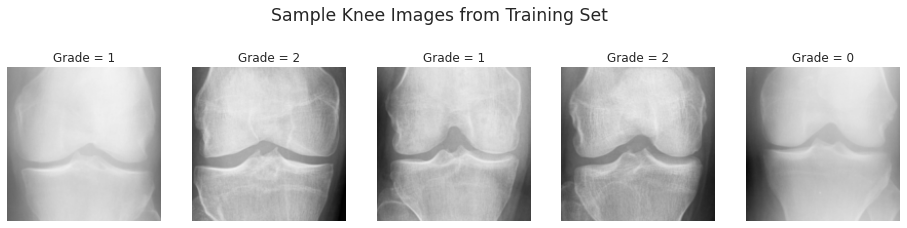

In [ ]:
plt.figure(figsize=(16, 4))
for i in range(1):
    images, labels = next(train_generator)
    for i in range(5):
        ax = plt.subplot(1,5,i+1)
        ax.axis('off')
        plt.imshow(images[i].squeeze().astype('uint8'),cmap='gray')
        ax.set_title('Grade = ' + str(int(labels[i])))
_ = plt.suptitle('Sample Knee Images from Training Set', size='xx-large')

train_generator.reset()

In [ ]:
def plot_distribution(set_of_files, title):
    f, ax = plt.subplots(figsize=(16,6))
    keys = sorted(list(set_of_files.keys()))
    vals = [len(set_of_files[k]) for k in keys]
    sns.barplot(x=keys, y=vals, palette="Blues_d")
    plt.xlabel('Knee Severity Grade')
    plt.title(title)

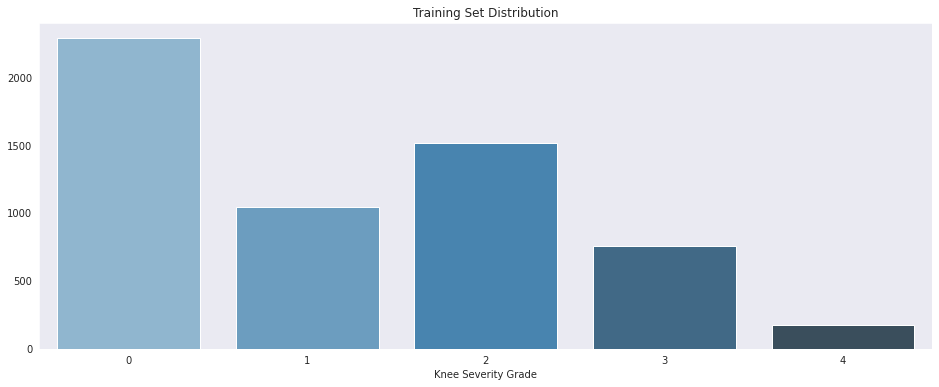

In [ ]:
plot_distribution(train_files, 'Training Set Distribution')

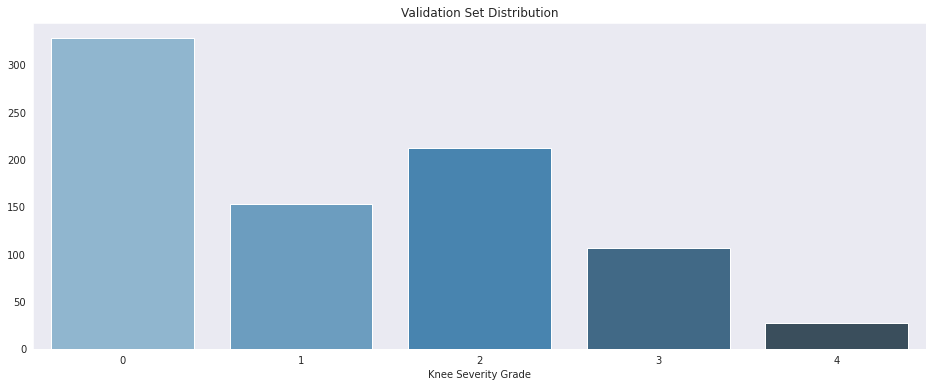

In [ ]:
plot_distribution(val_files, 'Validation Set Distribution')

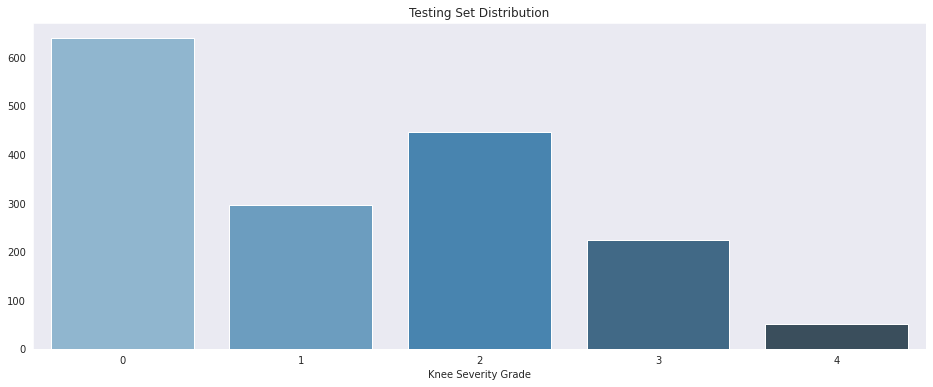

In [ ]:
plot_distribution(test_files, 'Testing Set Distribution')

## 4 Model - Transfer Learning - DenseNet201

### 4.1 Building the model

In [ ]:
img_height = 150
img_width = 150

base_model = DenseNet201(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(img_height, img_width, 3),
    include_top=False)  # Do not include the ImageNet classifier at the top.

74842112/74836368 [==============================] - 1s 0us/step


In [ ]:
base_model.trainable = False

In [ ]:
inputs = Input(shape=(img_height, img_width, 3))

## for DenseNet, add a rescaling layer to input
x = Rescaling(1./255)(inputs)

x = base_model(x, training=False)

# Convert features of shape `base_model.output_shape[1:]` to vectors
x = GlobalAveragePooling2D()(x)

x = Dropout(0.2)(x)
x = Dense(512, activation='relu')(x)

num_classes = 5

outputs = Dense(num_classes, activation='softmax')(x)
model = Model(inputs, outputs)

In [ ]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy', 
    metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
rescaling (Rescaling)        (None, 150, 150, 3)       0         
_________________________________________________________________
densenet201 (Functional)     (None, 4, 4, 1920)        18321984  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1920)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1920)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               983552    
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 2565  

Since we can see from our earlier distribution plots that we have imbalanced data, we will use __class weights__ to aid our model.

In [ ]:
train_labels_from_files = []
for k, v in train_files.items():
    num_files = len(v)
    print('grade', k, 'contains', num_files, 'images')
    train_labels_from_files.extend([int(k)]* num_files)
print('total number of images:', len(train_labels_from_files))

grade 3 contains 757 images
grade 0 contains 2286 images
grade 1 contains 1046 images
grade 4 contains 173 images
grade 2 contains 1516 images
total number of images: 5778


In [ ]:
class_weights_dict = dict(enumerate(class_weight.compute_class_weight(class_weight='balanced', classes=np.asarray(range(5)), y=train_labels_from_files)))
print(class_weights_dict)

{0: 0.5055118110236221, 1: 1.1047801147227534, 2: 0.7622691292875989, 3: 1.5265521796565389, 4: 6.679768786127168}


In [ ]:
num_epochs = 12

step_size_train = train_generator.n // train_generator.batch_size + 1
step_size_val = val_generator.n // val_generator.batch_size + 1

history = model.fit(train_generator, 
                    steps_per_epoch = step_size_train,
                    validation_data = val_generator, 
                    validation_steps = step_size_val,
                    epochs = num_epochs, 
                    class_weight = class_weights_dict)

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Epoch 1/12
289/289 [==============================] - 441s 1s/step - loss: 1.3600 - accuracy: 0.3579 - val_loss: 1.2904 - val_accuracy: 0.3462
Epoch 2/12
289/289 [==============================] - 434s 2s/step - loss: 1.1478 - accuracy: 0.4382 - val_loss: 1.2457 - val_accuracy: 0.4613
Epoch 3/12
289/289 [==============================] - 431s 1s/step - loss: 1.1027 - accuracy: 0.4515 - val_loss: 1.1127 - val_accuracy: 0.5291
Epoch 4/12
289/289 [==============================] - 428s 1s/step - loss: 1.0536 - accuracy: 0.4706 - val_loss: 1.1973 - val_accuracy: 0.4794
Epoch 5/12
289/289 [==============================] - 427s 1s/step - loss: 1.0419 - accuracy: 0.4740 - val_loss: 1.0937 - val_accuracy: 0.5472
Epoch 6/12
289/289 [==============================] - 430s 1s/step - loss: 1.0140 - accuracy: 0.4870 - val_loss: 1.2110 - val_accuracy: 0.4153
Epoc

### 4.2 Training and Validation Accuracy and Loss

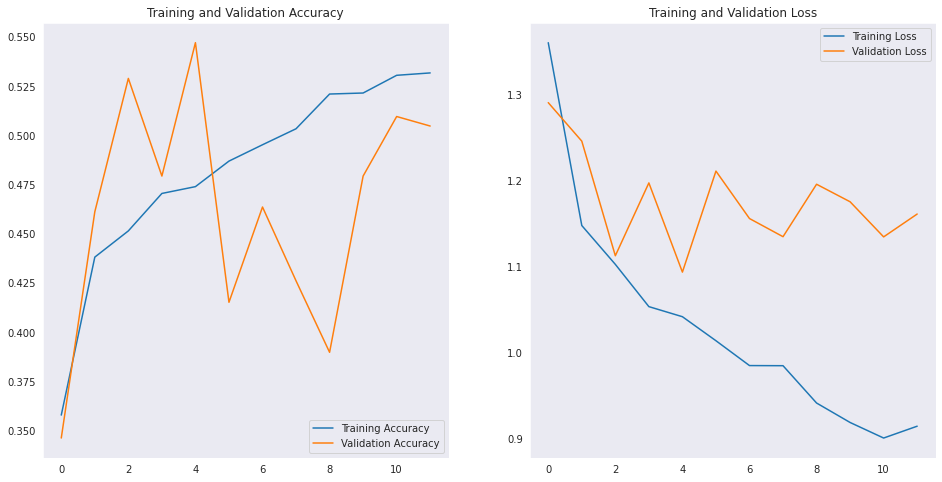

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(num_epochs)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### 4.3 Predictions on test set

In [ ]:
test_loss, test_accuracy = model.evaluate(test_generator)

83/83 [==============================] - 109s 1s/step - loss: 1.1372 - accuracy: 0.5036


#### 4.3.1 Model accuracy

In [ ]:
print('Accuracy of model on test set: {:.2f} percent'.format(100*test_accuracy))

Accuracy of model on test set: 50.36 percent


#### 4.3.2 Confusion matrix

In [ ]:
test_generator.reset()
Y_pred = model.predict(test_generator, steps=(test_generator.n // test_generator.batch_size)+1)
y_pred = np.argmax(Y_pred, axis=1)

In [ ]:
cm = confusion_matrix(test_generator.classes, y_pred)
cm

array([[472, 104,  51,   9,   3],
       [144,  75,  64,   9,   4],
       [116,  76, 158,  62,  35],
       [ 14,  20,  42,  84,  63],
       [  0,   0,   0,   6,  45]])

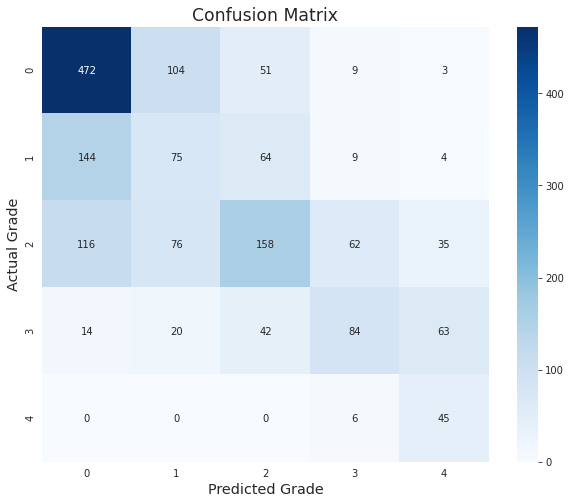

In [41]:
plt.figure(figsize=(10, 8))
_ = sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues')
plt.xlabel('Predicted Grade', size='x-large')
plt.ylabel('Actual Grade', size='x-large')
_ = plt.title('Confusion Matrix',size='xx-large')

#### 4.3.3 Classification Report

In [ ]:
print("Classification Report:")
clr = classification_report(test_generator.classes, y_pred, zero_division=0)
print(clr)

Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.74      0.68       639
           1       0.27      0.25      0.26       296
           2       0.50      0.35      0.41       447
           3       0.49      0.38      0.43       223
           4       0.30      0.88      0.45        51

    accuracy                           0.50      1656
   macro avg       0.44      0.52      0.45      1656
weighted avg       0.50      0.50      0.49      1656



#### 4.3.4 Sample images from test set

We will randomly fetch 5 image files from each of the 5 classes to load and display with their actual grade along with their predicted grade.

In [ ]:
from random import sample

test_sample_files = []

# randomly fetch the files
for i in range(5):
    class_name = str(i)
    for file_name in sample(test_files[class_name], 5):
        test_sample_files.append( (class_name, file_name) )
test_sample_files.sort()

In [ ]:
# load the images
test_sample_images = []
test_sample_actual_labels = []
for i, (class_name, file_name) in enumerate(test_sample_files):
    img_path = test_directory + '/' + class_name + '/' + file_name
    img = image.load_img(img_path, target_size=(150,150), interpolation='bilinear')
    x = image.img_to_array(img)
    test_sample_images.append(x)
    test_sample_actual_labels.append(int(class_name))
    
# convert list into numpy array
test_sample_images = np.asarray(test_sample_images)

In [ ]:
# run the prediction
test_sample_predictions = model.predict(test_sample_images)
test_sample_prediction_labels = test_sample_predictions.argmax(axis=1)

In [ ]:
test_sample_accuracy_score = 100 * np.sum(test_sample_actual_labels == test_sample_prediction_labels)/len(test_sample_files)
print('Accuracy of model: {:.2f} percent'.format(test_sample_accuracy_score))

Accuracy of model: 52.00 percent


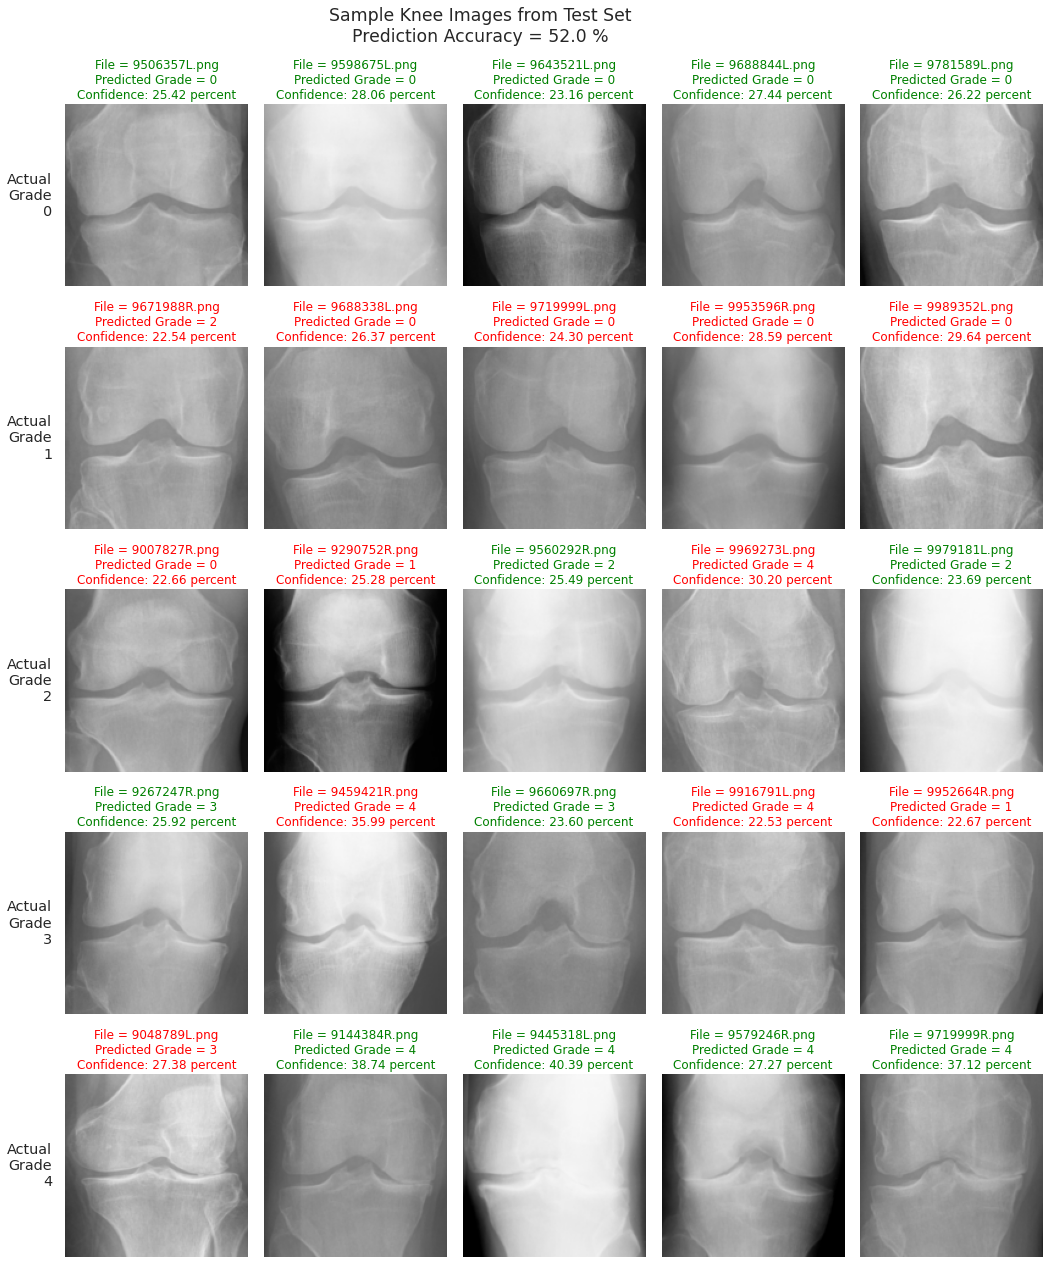

In [42]:
# plot the images

rows = ['Actual\nGrade\n{}'.format(grade) for grade in range(5)]

fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(16, 18))

for ax, row in zip(axes[:,0], rows):
    ax.annotate(row, xy=(0, 0.05), xytext=(-ax.yaxis.labelpad - 5, 0),
                xycoords=ax.yaxis.label, textcoords='offset points',
                size='x-large', ha='right', va='center')

for i in range(5):
    for j in range(5):
        img_num = i*5 + j
        ax = axes[i, j]
        
        # can't just turn off the axis if we want to keep y label
        # must turn each element of axis off
        ax.xaxis.set_visible(False)
        plt.setp(ax.spines.values(), visible=False)
        ax.tick_params(left=False, labelleft=False)
        
        ax.imshow(test_sample_images[img_num].squeeze().astype('uint8'))
        
        file_name = test_sample_files[img_num][1]
        pred_grade = test_sample_prediction_labels[img_num]
        score = 100*np.max(tf.nn.softmax(test_sample_predictions[img_num]))
        title = "File = {}\nPredicted Grade = {}\nConfidence: {:.2f} percent".format(file_name, pred_grade, score)
        
        # if correctly predicted, set title color to green
        # note that i == actual grade
        title_color = 'green' if pred_grade == i else 'red'
        ax.set_title(title, color=title_color) 
_ = plt.suptitle('Sample Knee Images from Test Set\nPrediction Accuracy = {} %'.format(test_sample_accuracy_score), size='xx-large')
plt.tight_layout(rect=[0.08, 0, 1, 0.95])

## 5 Model - Transfer Learning - Xception

### 5.1 Building the model

In [ ]:
base_model = Xception(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(TARGET_IMG_HEIGHT, TARGET_IMG_WIDTH, 3),
    include_top=False)  # Do not include the ImageNet classifier at the top.

83689472/83683744 [==============================] - 1s 0us/step


In [ ]:
base_model.trainable = False

In [ ]:
inputs = Input(shape=(TARGET_IMG_HEIGHT, TARGET_IMG_WIDTH, 3))

# Pre-trained Xception weights requires that input be normalized
# from (0, 255) to a range (-1., +1.), the normalization layer
# does the following, outputs = (inputs - mean) / sqrt(var)
norm_layer = keras.layers.experimental.preprocessing.Normalization()
mean = np.array([127.5] * 3)
var = mean ** 2
# Scale inputs to [-1, +1]
x = norm_layer(inputs)
norm_layer.set_weights([mean, var])

## for DenseNet, add a rescaling layer to input
#x = Rescaling(1./255)(inputs)

x = base_model(x, training=False)

# Convert features of shape `base_model.output_shape[1:]` to vectors
x = GlobalAveragePooling2D()(x)

x = Dropout(0.2)(x)
x = Dense(512, activation='relu')(x)

num_classes = 5

outputs = Dense(num_classes, activation='softmax')(x)
model = Model(inputs, outputs)

In [ ]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy', 
    metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
normalization (Normalization (None, 150, 150, 3)       7         
_________________________________________________________________
xception (Functional)        (None, 5, 5, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               1049088   
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 2565  

Since we can see from our earlier distribution plots that we have imbalanced data, we will use __class weights__ to aid our model.

In [ ]:
train_labels_from_files = []
for k, v in train_files.items():
    num_files = len(v)
    print('grade', k, 'contains', num_files, 'images')
    train_labels_from_files.extend([int(k)]* num_files)
print('total number of images:', len(train_labels_from_files))

grade 3 contains 757 images
grade 4 contains 173 images
grade 2 contains 1516 images
grade 1 contains 1046 images
grade 0 contains 2286 images
total number of images: 5778


In [ ]:
class_weights_dict = dict(enumerate(class_weight.compute_class_weight(class_weight='balanced', classes=np.asarray(range(5)), y=train_labels_from_files)))
print(class_weights_dict)

{0: 0.5055118110236221, 1: 1.1047801147227534, 2: 0.7622691292875989, 3: 1.5265521796565389, 4: 6.679768786127168}


In [ ]:
num_epochs = 12

step_size_train = train_generator.n // train_generator.batch_size + 1
step_size_val = val_generator.n // val_generator.batch_size + 1

history = model.fit(train_generator, 
                    steps_per_epoch = step_size_train,
                    validation_data = val_generator, 
                    validation_steps = step_size_val,
                    epochs = num_epochs, 
                    class_weight = class_weights_dict)

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Epoch 1/12
181/181 [==============================] - 327s 2s/step - loss: 1.4325 - accuracy: 0.3219 - val_loss: 1.3356 - val_accuracy: 0.3293
Epoch 2/12
181/181 [==============================] - 326s 2s/step - loss: 1.2525 - accuracy: 0.3856 - val_loss: 1.4347 - val_accuracy: 0.3705
Epoch 3/12
181/181 [==============================] - 371s 2s/step - loss: 1.1990 - accuracy: 0.4091 - val_loss: 1.2330 - val_accuracy: 0.4370
Epoch 4/12
181/181 [==============================] - 330s 2s/step - loss: 1.1487 - accuracy: 0.4263 - val_loss: 1.2780 - val_accuracy: 0.3983
Epoch 5/12
181/181 [==============================] - 326s 2s/step - loss: 1.1096 - accuracy: 0.4368 - val_loss: 1.2107 - val_accuracy: 0.4504
Epoch 6/12
181/181 [==============================] - 375s 2s/step - loss: 1.0989 - accuracy: 0.4567 - val_loss: 1.3138 - val_accuracy: 0.3015
Epoc

### 5.2 Training and Validation Accuracy and Loss

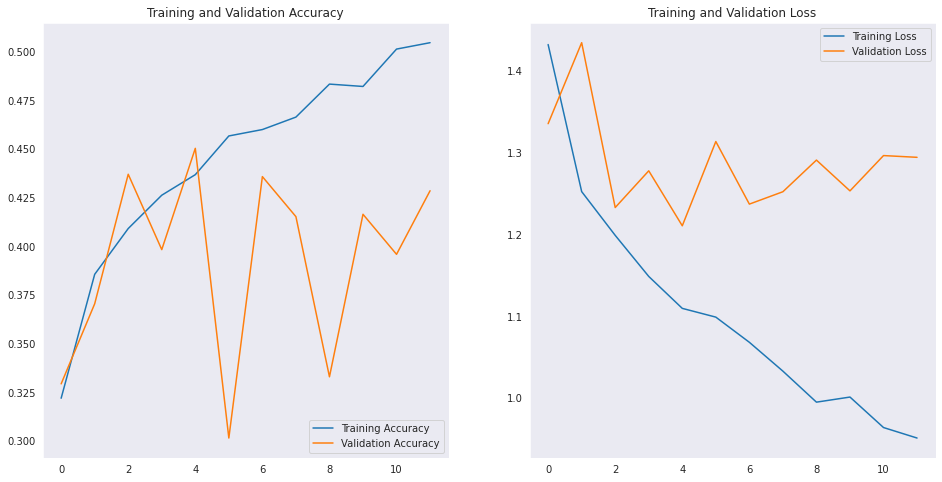

In [42]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(num_epochs)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### 5.3 Predictions on test set

In [ ]:
test_loss, test_accuracy = model.evaluate(test_generator)

52/52 [==============================] - 86s 2s/step - loss: 1.3271 - accuracy: 0.4070


#### 5.3.1 Model accuracy

In [ ]:
print('Accuracy of model on test set: {:.2f} percent'.format(100*test_accuracy))

Accuracy of model on test set: 40.70 percent


#### 5.3.2 Confusion matrix

In [ ]:
test_generator.reset()
Y_pred = model.predict(test_generator, steps=(test_generator.n // test_generator.batch_size)+1)
y_pred = np.argmax(Y_pred, axis=1)

In [ ]:
cm = confusion_matrix(test_generator.classes, y_pred)
cm

array([[360, 145,  37,  94,   3],
       [125,  73,  32,  59,   7],
       [115, 103,  84, 131,  14],
       [ 28,  18,  21, 132,  24],
       [  0,   0,   3,  23,  25]])

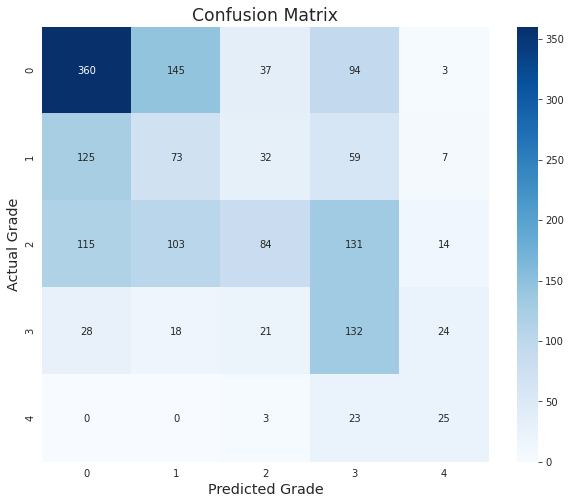

In [ ]:
plt.figure(figsize=(10, 8))
_ = sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues')
plt.xlabel('Predicted Grade', size='x-large')
plt.ylabel('Actual Grade', size='x-large')
_ = plt.title('Confusion Matrix',size='xx-large')

#### 5.3.3 Classification Report

In [ ]:
print("Classification Report:")
clr = classification_report(test_generator.classes, y_pred, zero_division=0)
print(clr)

Classification Report:
              precision    recall  f1-score   support

           0       0.57      0.56      0.57       639
           1       0.22      0.25      0.23       296
           2       0.47      0.19      0.27       447
           3       0.30      0.59      0.40       223
           4       0.34      0.49      0.40        51

    accuracy                           0.41      1656
   macro avg       0.38      0.42      0.37      1656
weighted avg       0.44      0.41      0.40      1656



#### 5.3.4 Sample images from test set

We will randomly fetch 5 image files from each of the 5 classes to load and display with their actual grade along with their predicted grade.

In [ ]:
from random import sample

test_sample_files = []

# randomly fetch the files
for i in range(5):
    class_name = str(i)
    for file_name in sample(test_files[class_name], 5):
        test_sample_files.append( (class_name, file_name) )
test_sample_files.sort()

In [ ]:
# load the images
test_sample_images = []
test_sample_actual_labels = []
for i, (class_name, file_name) in enumerate(test_sample_files):
    img_path = test_directory + '/' + class_name + '/' + file_name
    img = image.load_img(img_path, target_size=(TARGET_IMG_HEIGHT, TARGET_IMG_WIDTH), interpolation=INTERPOLATION_BILINEAR)
    x = image.img_to_array(img)
    test_sample_images.append(x)
    test_sample_actual_labels.append(int(class_name))
    
# convert list into numpy array
test_sample_images = np.asarray(test_sample_images)

In [ ]:
# run the prediction
test_sample_predictions = model.predict(test_sample_images)
test_sample_prediction_labels = test_sample_predictions.argmax(axis=1)

In [ ]:
test_sample_accuracy_score = 100 * np.sum(test_sample_actual_labels == test_sample_prediction_labels)/len(test_sample_files)
print('Accuracy of model: {:.2f} percent'.format(test_sample_accuracy_score))

Accuracy of model: 24.00 percent


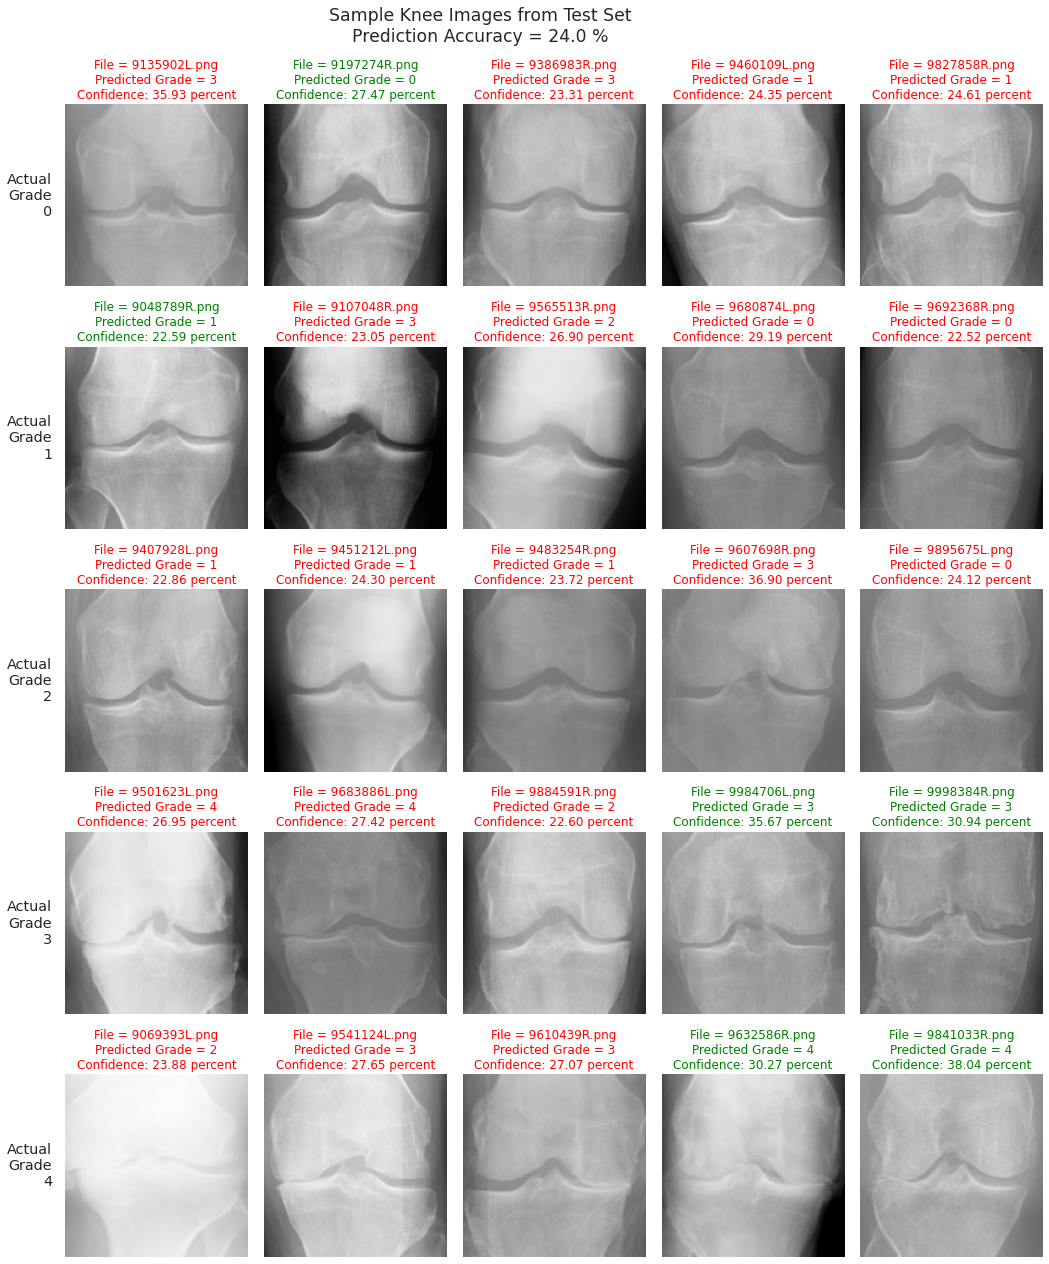

In [ ]:
# plot the images

rows = ['Actual\nGrade\n{}'.format(grade) for grade in range(5)]

fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(16, 18))

for ax, row in zip(axes[:,0], rows):
    ax.annotate(row, xy=(0, 0.05), xytext=(-ax.yaxis.labelpad - 5, 0),
                xycoords=ax.yaxis.label, textcoords='offset points',
                size='x-large', ha='right', va='center')

for i in range(5):
    for j in range(5):
        img_num = i*5 + j
        ax = axes[i, j]
        
        # can't just turn off the axis if we want to keep y label
        # must turn each element of axis off
        ax.xaxis.set_visible(False)
        plt.setp(ax.spines.values(), visible=False)
        ax.tick_params(left=False, labelleft=False)
        
        ax.imshow(test_sample_images[img_num].squeeze().astype('uint8'))
        
        file_name = test_sample_files[img_num][1]
        pred_grade = test_sample_prediction_labels[img_num]
        score = 100*np.max(tf.nn.softmax(test_sample_predictions[img_num]))
        title = "File = {}\nPredicted Grade = {}\nConfidence: {:.2f} percent".format(file_name, pred_grade, score)
        
        # if correctly predicted, set title color to green
        # note that i == actual grade
        title_color = 'green' if pred_grade == i else 'red'
        ax.set_title(title, color=title_color) 
_ = plt.suptitle('Sample Knee Images from Test Set\nPrediction Accuracy = {} %'.format(test_sample_accuracy_score), size='xx-large')
plt.tight_layout(rect=[0.08, 0, 1, 0.95])

### 6 Comparison of DenseNet201 to Xception

Transfer learning using DenseNet201 appears to outperform transfer learning using Xception. We will continue improving the model using DenseNet201.